Feature Extraction from pretrained models like VGG-16, VGG-19, ResNet-50, InceptionV3 and MobileNet and benchmark them using the Caltech101 dataset

In [ ]:
!mkdir -p ../../datasets
!pip install gdown
!gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp --output ../../datasets/caltech101.tar.gz
!tar -xvzf ../../datasets/caltech101.tar.gz --directory ../../datasets
!mv ../../datasets/101_ObjectCategories ../../datasets/caltech101
!rm -rf ../../datasets/caltech101/BACKGROUND_Google

In [ ]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D


Helper function  to choose any pretrained model with all the necessary details for our experiments.

In [ ]:
def model_picker(name):
    if (name == 'vgg16'):
        model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'vgg19'):
        model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'mobilenet'):
        model = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3),
                          pooling='max',
                          depth_multiplier=1,
                          alpha=1)
    elif (name == 'inception'):
        model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3),
                            pooling='max')
    elif (name == 'resnet'):
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')
    elif (name == 'xception'):
        model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='max')
    else:
        print("Specified model not available")
    return model

In [ ]:
model_architecture = 'resnet'
model = model_picker(model_architecture)

94781440/94765736 [==============================] - 0s 0us/step


Defining a function to extract image features given an image and a model. 

In [ ]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

Feature length the model generates by running on an example image. (image input by us) 

In [ ]:
try:
  import google.colab
  IS_COLAB_ENV = True
except:
  IS_COLAB_ENV = False

In [ ]:
IMG_PATH = '/content/dog.jpg'
if IS_COLAB_ENV:
  !curl https://raw.githubusercontent.com/PracticalDL/Practical-Deep-Learning-Book/master/sample-images/cat.jpg --output cat.jpg
  IMG_PATH = 'cat.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  661k  100  661k    0     0  1998k      0 --:--:-- --:--:-- --:--:-- 1998k


In [ ]:
features = extract_features('cat.jpg', model)
print("Total length of features for one image: ", len(features))

Total length of features for one image:  2048


Time taken to extract features of one image.  Depending on image size, the final time may be different and it depends on the time to read, resize, preprocess, and extract features.

In [ ]:
%timeit features = extract_features('cat.jpg', model)

10 loops, best of 5: 101 ms per loop


## Benchmarking time taken to extract features over the entire dataset

The time taken to extract features is dependent on a few factors such as image size, computing power etc. A better benchmark would be running the network over an entire dataset. A simple change to the existing code will allow this.

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                filepath = os.path.join(root, filename)
                if os.path.exists(filepath):
                  file_list.append(filepath)
                else:
                  print(filepath)
    return file_list

Running the extraction over the entire dataset and timing it.

In [ ]:
# path to the your datasets
root_dir = '../../datasets/caltech101'
filenames = sorted(get_file_list(root_dir))
print(len(filenames))

8677


In [ ]:
standard_feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    standard_feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8677 [00:00<?, ?it/s]

 Keras Image Generator functions

In [ ]:
batch_size = 128
datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory(root_dir,
                                        target_size=(224, 224),
                                        class_mode=None,
                                        shuffle=False)

num_images = len(generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

start_time = time.time()
feature_list = []
feature_list = model.predict_generator(generator, num_epochs)
end_time = time.time()

Found 8677 images belonging to 101 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
for i, features in enumerate(feature_list):
    feature_list[i] = features / norm(features)

feature_list = feature_list.reshape(len(feature_list), -1)

print("Num images   = ", len(generator.classes))
print("Shape of feature_list = ", feature_list.shape)
print("Time taken in sec = ", end_time - start_time)

Num images   =  8677
Shape of feature_list =  (2176, 2048)
Time taken in sec =  11.13357138633728


Features have been generated from the entire dataset of images, using two different methods.

In [ ]:
filenames = [root_dir + '/' + s for s in generator.filenames]

In [ ]:
pickle.dump(generator.classes, open('./class_ids-caltech101.pickle',
                                    'wb'))
pickle.dump(filenames, open('./filenames-caltech101.pickle', 'wb'))
pickle.dump(
    feature_list,
    open('./features-caltech101-' + model_architecture + '.pickle', 'wb'))

Training a finetuned model and saving the features.

In [ ]:
TRAIN_SAMPLES = 8677
NUM_CLASSES = 101
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(root_dir,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')

Found 8677 images belonging to 101 classes.


In [ ]:
def model_maker():
    base_model = ResNet50(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [ ]:
model_finetuned = model_maker()
model_finetuned.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_finetuned.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
    epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
68/68 [==============================] - 29s 377ms/step - loss: 3.7444 - acc: 0.2174
Epoch 2/10
68/68 [==============================] - 26s 380ms/step - loss: 2.7956 - acc: 0.3690
Epoch 3/10
68/68 [==============================] - 26s 380ms/step - loss: 2.2943 - acc: 0.4559
Epoch 4/10
68/68 [==============================] - 26s 382ms/step - loss: 1.9822 - acc: 0.5221
Epoch 5/10
68/68 [==============================] - 26s 385ms/step - loss: 1.7315 - acc: 0.5781
Epoch 6/10
68/68 [==============================] - 26s 386ms/step - loss: 1.5682 - acc: 0.6039
Epoch 7/10
68/68 [==============================] - 26s 386ms/step - loss: 1.4708 - acc: 0.6128
Epoch 8/10
68/68 [==============================] - 27s 392ms/step - loss: 1.3476 - acc: 0.6425
Epoch 9/10
68/68 [==============================] - 26s 388ms/step - loss: 1.2478 - acc: 0.6641
Epoch 10/10
68/68 [==============================] - 26s 384ms/step - loss: 1.1652 - acc: 0.6850


In [ ]:
model_finetuned.save('./model-finetuned.h5')

In [ ]:
start_time = time.time()
feature_list_finetuned = []
feature_list_finetuned = model_finetuned.predict(generator, num_epochs)
end_time = time.time()

for i, features_finetuned in enumerate(feature_list_finetuned):
    feature_list_finetuned[i] = features_finetuned / norm(features_finetuned)

feature_list = feature_list_finetuned.reshape(len(feature_list_finetuned), -1)

print("Num images   = ", len(feature_list_finetuned) )
print("Shape of feature_list = ", feature_list.shape)
print("Time taken in sec = ", end_time - start_time)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Num images   =  2176
Shape of feature_list =  (2176, 101)
Time taken in sec =  11.122774362564087


In [ ]:
pickle.dump(
    feature_list,
    open('./features-caltech101-resnet-finetuned.pickle', 'wb'))

In [ ]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
filenames = pickle.load(open('./filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('/content/features-caltech101-resnet.pickle',
                                'rb'))
class_ids = pickle.load(open('./class_ids-caltech101.pickle', 'rb'))

In [ ]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  8677
Number of features per image =  2048


In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

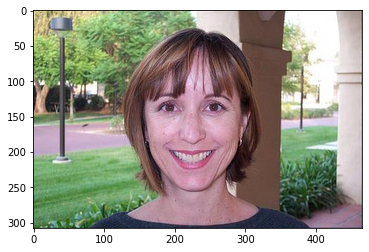

In [ ]:
random_index = 75
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

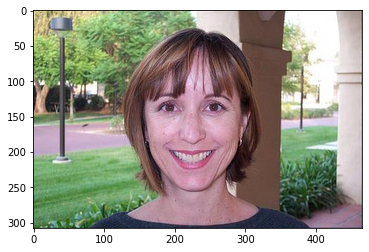

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]), interpolation='lanczos')

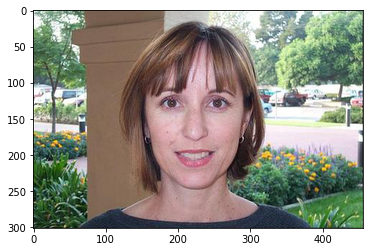

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]), interpolation='lanczos')

In [ ]:
for i in range(5):
    print(distances[0][i])

2.1073424e-08
0.51936096
0.53159654
0.5465547
0.58122253


In [ ]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        

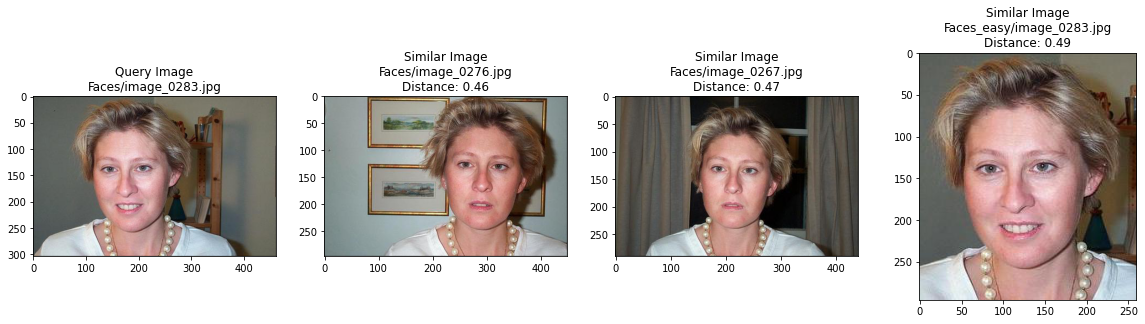

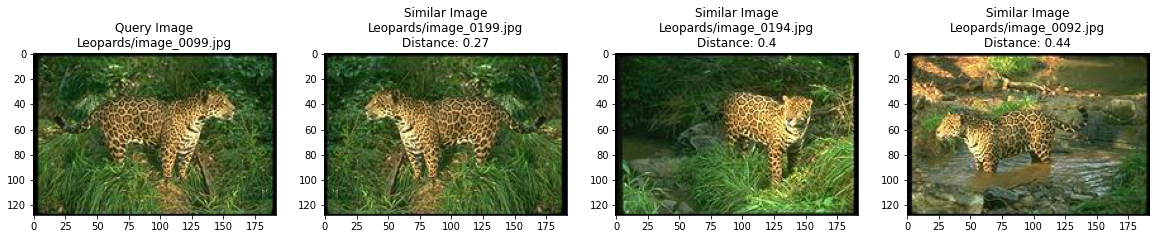

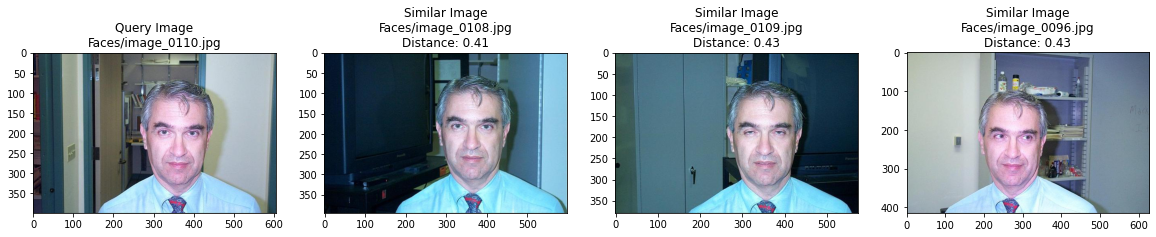

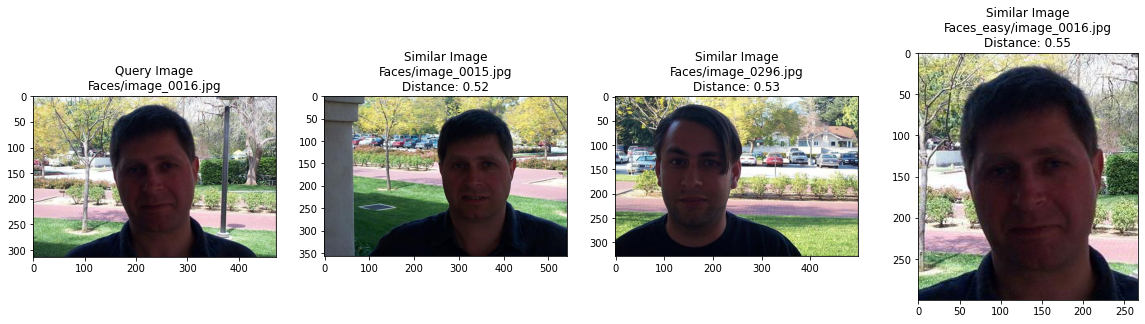

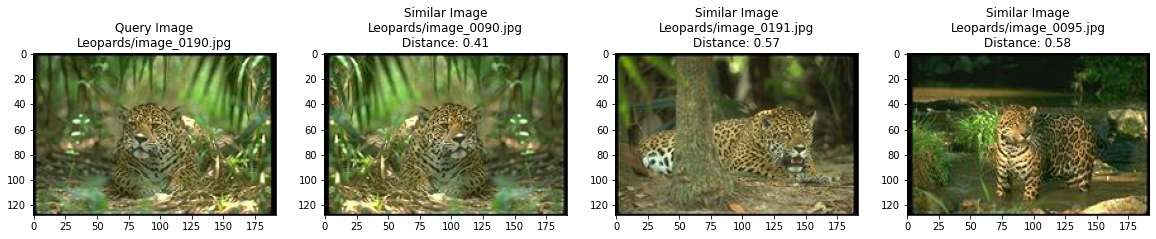

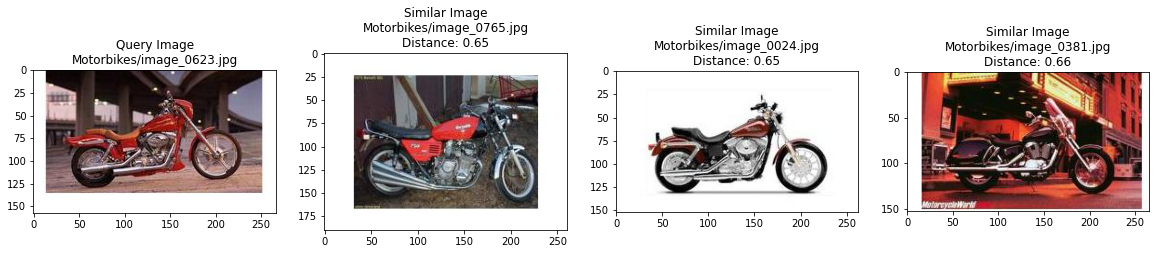

In [ ]:
for i in range(6):
    random_image_index = random.randint(0, 2000)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

In [ ]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  1.0054654
Max distance between all photos:  1.1862475
Median distance among most similar photos:  0.5689856


In [ ]:
selected_features = feature_list[:]
selected_class_ids = class_ids[:]
selected_filenames = filenames[:]

The t-SNE algorithm is useful for visualizing high dimensional data.

In [ ]:
from sklearn.manifold import TSNE

# You can play with these values and see how the results change
n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(selected_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2176 samples in 0.004s...
[t-SNE] Computed neighbors for 2176 samples in 0.486s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2176
[t-SNE] Computed conditional probabilities for sample 2000 / 2176
[t-SNE] Computed conditional probabilities for sample 2176 / 2176
[t-SNE] Mean sigma: 0.189347
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.631500
[t-SNE] KL divergence after 1000 iterations: 0.980247
t-SNE done! Time elapsed: 13.814987659454346 seconds


### Plot a scatter plot from the generated t-SNE results

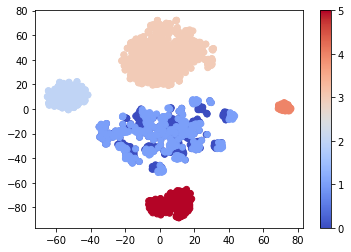

In [ ]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids[:2176],
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

### Helper function to plot images in 2D for t-SNE.

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data


def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [ ]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

### Visualize the patterns in the images using t-SNE

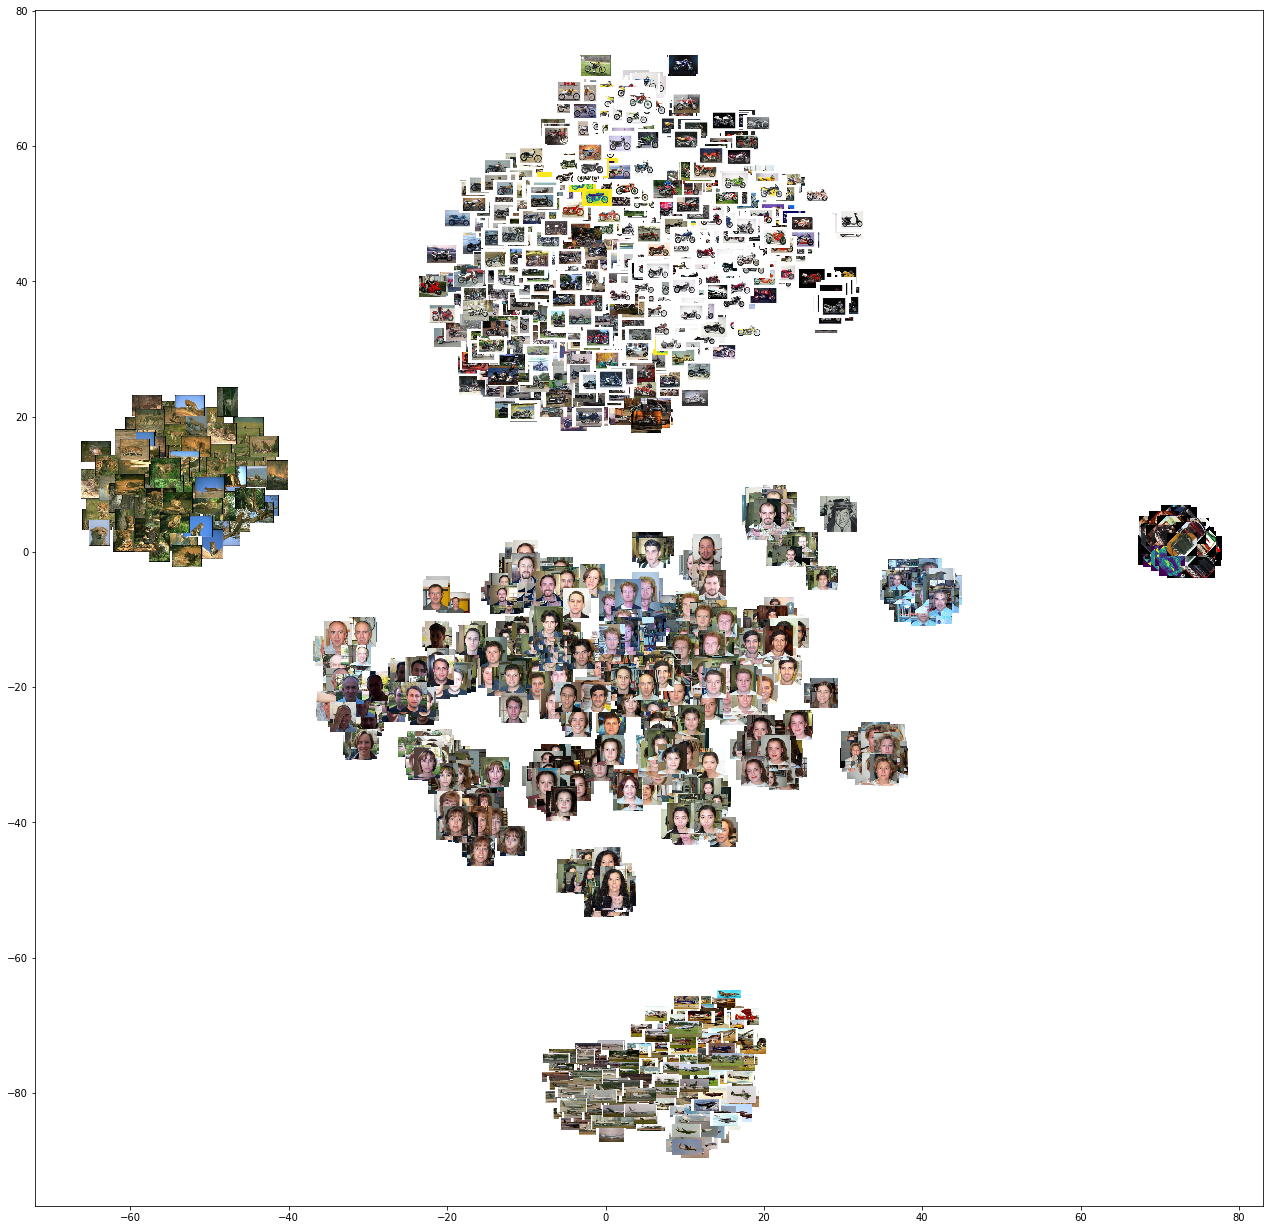

In [ ]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

The `show_tsne` function piles images one on top of each other, making it harder to discern the patterns as the density of images is high. To help visualize the patterns better, we write another helper function `tsne_to_grid_plotter_manual` that spaces the images evenly.

In [ ]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()

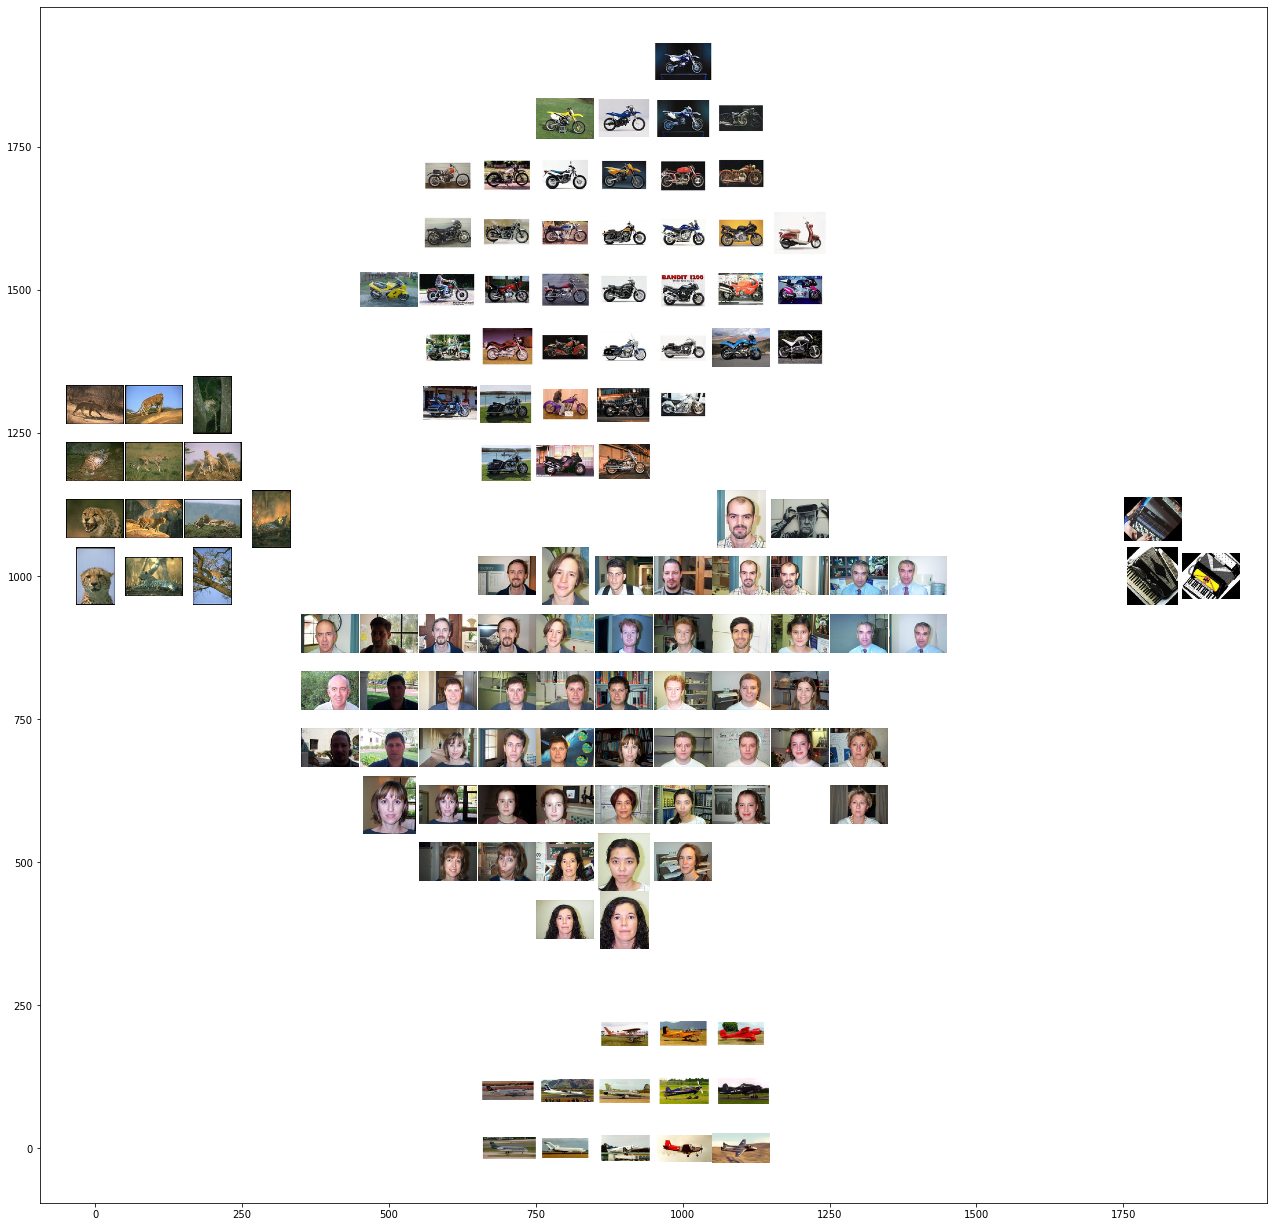

In [ ]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames[:2176])